<a href="https://colab.research.google.com/github/viraj-sampat/vwm_research/blob/main/digit_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q ipympl
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget
import torch
import torch.nn as nn
import torch.optim as optim
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torchvision
from torchvision import transforms
from IPython.display import IFrame
from IPython.display import display_pdf
from IPython.display import FileLink
from IPython.display import display
import os
!pip install torchmetrics
from torchmetrics import PearsonCorrCoef

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 8.1 MB/s eta 0:00:00


# Import Data

In [ ]:
training_data = torchvision.datasets.MNIST('dataset', train=True,download=True, transform = transforms.ToTensor())
test_data = torchvision.datasets.MNIST('dataset', train=False, download=True, transform = transforms.ToTensor())

batch_size = 256
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 91400701.39it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 83541857.81it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25207360.39it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3550890.73it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [ ]:
print(len(train_loader))
print(len(test_loader))

235
40


# Visualize Data

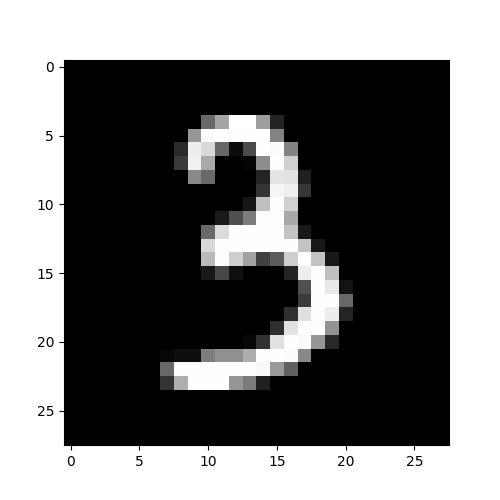

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
#images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

# Create Model

In [ ]:
class MNISTAutoencoder(nn.Module):
    def __init__(self):
        super(MNISTAutoencoder, self).__init__()
        
        output_channels = 1
        kernel_size = 4
        self.encoding_dimension = 2
        
        # Encoder with Convoltional Layer
        self.encoder1 = nn.Sequential(
            nn.Conv2d(1, output_channels, kernel_size = kernel_size),
            nn.ReLU(True),
            nn.Flatten(),
            #nn.Linear(28**2, self.encoding_dimension),
            nn.Linear(output_channels*((28-kernel_size+1)**2), 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128,self.encoding_dimension),
            #nn.ReLU(True)
            #nn.Sigmoid()
            )
        self.decoder = nn.Sequential(
            nn.Linear(self.encoding_dimension, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, output_channels*((28-kernel_size+1)**2)),
            #nn.Linear(self.encoding_dimension, 28**2),
            nn.ReLU(True),
            nn.Unflatten(1, (output_channels, 28-kernel_size+1, 28-kernel_size+1)),
            #nn.Unflatten(1, (output_channels,28, 28)),
            nn.ConvTranspose2d(output_channels, 1, kernel_size = kernel_size),
            nn.Sigmoid()
            )
        
        # Encoder with FC Linear Layers
        self.encoder2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28**2, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128,self.encoding_dimension),
            #nn.Linear(output_channels*((28-kernel_size+1)**2), self.encoding_dimension),
            #nn.ReLU(True)
            #nn.Sigmoid()
            )
        self.decoder = nn.Sequential(
            nn.Linear(self.encoding_dimension, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 28**2),
            #nn.Unflatten(1, (output_channels, 28-kernel_size+1, 28-kernel_size+1)),
            nn.Unflatten(1, (output_channels,28, 28)),
            #nn.ConvTranspose2d(output_channels, 1, kernel_size = kernel_size),
            nn.Sigmoid()
            )
        
        enc = 2
        if enc == 1:
          self.encoder = self.encoder1
        else:
          self.encoder = self.encoder2

    def add_noise(self, x):
        num_discrete = int(self.encoding_dimension/2)
        std = 0.1
        x[:,0:num_discrete] = x[:,0:num_discrete] + torch.randn(len(x), num_discrete)*std
        return x
        # num_continuous = int(self.encoding_dimension/2)
        # num_discrete = self.encoding_dimension - num_continuous
        # std = 1
        # continuous = x[0:num_continuous]
        # discrete = x[0:num_continuous]
        # x = torch.concat((continuous,discrete), 0)


    def forward(self, x):
        x = self.encoder(x)
        x = torch.atan(x)
        #x = self.add_noise(x.clone())
        x = torch.tan(x)
        x = self.decoder(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MNISTAutoencoder().to(device)

# Initialize Loss and Optimizer

In [ ]:
#loss_function = torch.nn.MSELoss()
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
#optimizer = optim.SGD(model.parameters(), lr=1, momentum=0.9)

# Train Model

In [ ]:
num_epochs = 20
print('Training Model...')
for epoch in range(num_epochs):
    training_loss = 0.0
    for data in train_loader:
        image, _ = data
        image = image.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_function(output, image)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    print('Epoch {}/{}, Loss: {:.4f}'.format(epoch+1, num_epochs, training_loss/len(train_loader)))
        
        

Training Model...
Epoch 1/20, Loss: 0.2620
Epoch 2/20, Loss: 0.2081
Epoch 3/20, Loss: 0.1972
Epoch 4/20, Loss: 0.1926
Epoch 5/20, Loss: 0.1894
Epoch 6/20, Loss: 0.1868
Epoch 7/20, Loss: 0.1845
Epoch 8/20, Loss: 0.1827
Epoch 9/20, Loss: 0.1811
Epoch 10/20, Loss: 0.1799
Epoch 11/20, Loss: 0.1787
Epoch 12/20, Loss: 0.1780
Epoch 13/20, Loss: 0.1770
Epoch 14/20, Loss: 0.1762
Epoch 15/20, Loss: 0.1754
Epoch 16/20, Loss: 0.1748
Epoch 17/20, Loss: 0.1742
Epoch 18/20, Loss: 0.1736
Epoch 19/20, Loss: 0.1732
Epoch 20/20, Loss: 0.1728


In [ ]:
# train_dataiter = iter(train_loader)
# train_images, train_labels = next(train_dataiter)

# test_dataiter = iter(test_loader)
# test_images, test_labels = next(test_dataiter)

train_correlation = []
test_correlation = []
pearson = PearsonCorrCoef()

print('training correlation:')
for train_images,train_labels in train_loader:
  train_output = model(train_images)
  corr = pearson(train_output.flatten(), train_images.flatten()).item()
  train_correlation.append(corr)

train_correlation = np.mean(train_correlation)
print(train_correlation)

print('test correlation:')
for test_images,test_labels in test_loader:
  test_output = model(test_images)
  corr = pearson(test_output.flatten(), test_images.flatten()).item()
  test_correlation.append(corr)

test_correlation = np.mean(test_correlation)
print(test_correlation)

training correlation:
0.7812303208290262
test correlation:
0.7806148633360863


In [ ]:
train_dataiter = iter(train_loader)
train_images, train_labels = next(train_dataiter)

test_dataiter = iter(test_loader)
test_images, test_labels = next(test_dataiter)

train_output = model(train_images)

train_output = train_output.detach().numpy()

Example Training Images and Reconstructions...


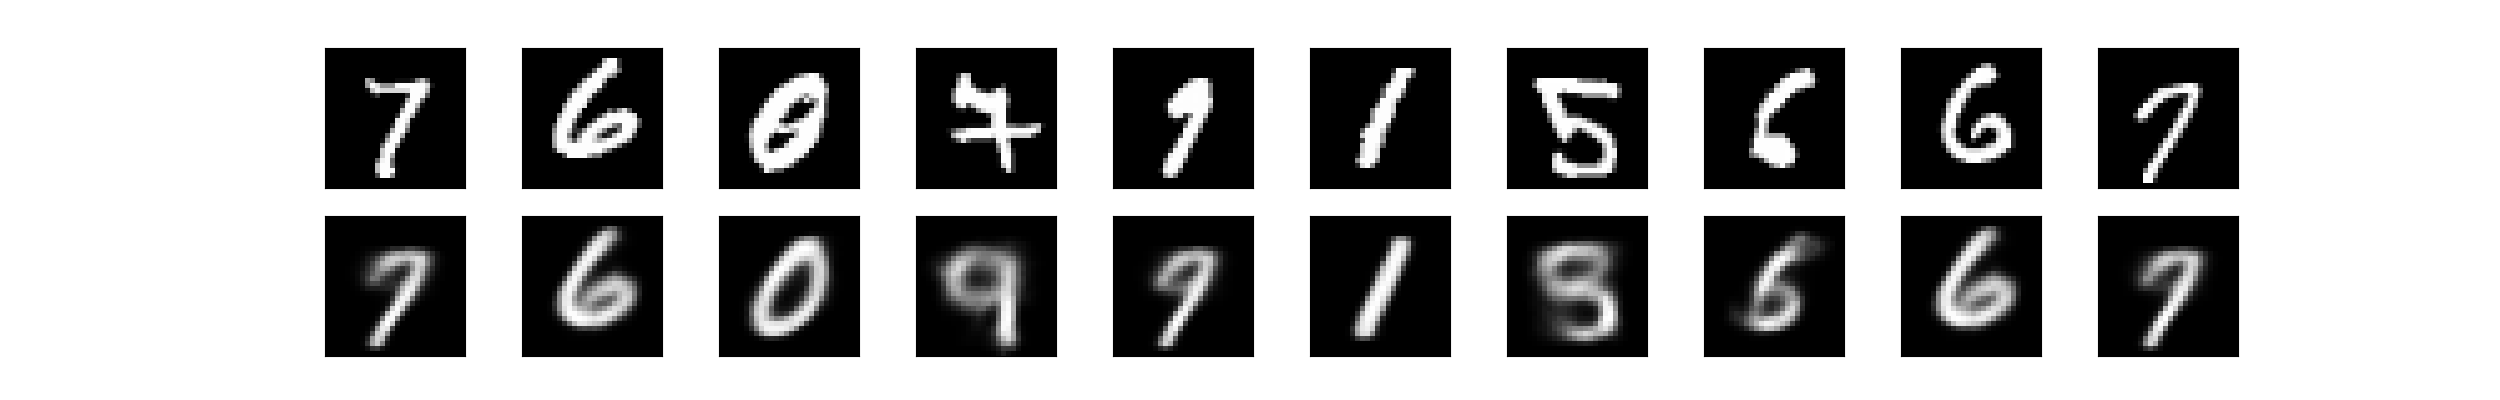

In [ ]:
print('Example Training Images and Reconstructions...')
# output is resized into a batch of images
#train_outputs = train_output.view(batch_size, 1, 28, 28)

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([train_images, train_output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

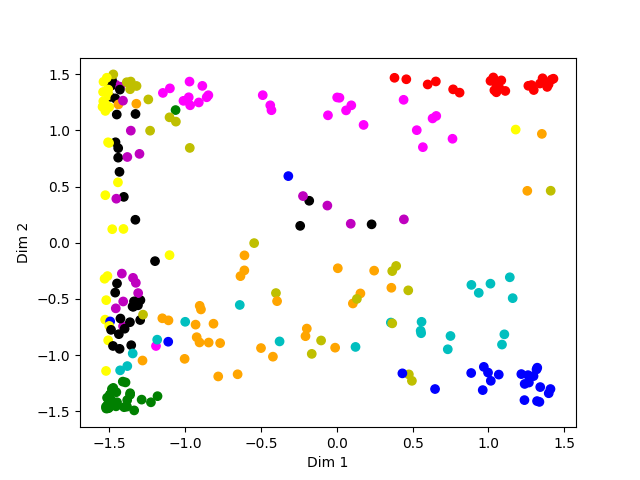

In [ ]:
train_enc = torch.atan(model.encoder(train_images))

x = train_enc[:,0].detach()
y = train_enc[:,1].detach()
colormap = np.array(['r', 'g', 'b', 'c', 'm', 'y','magenta','yellow', 'orange', 'k'])
fig = plt.figure()
plt.scatter(x,y,  c = colormap[train_labels])
plt.xlabel("Dim 1") 
plt.ylabel("Dim 2")
plt.show()

In [ ]:
# !pip install -q ipympl
# from google.colab import output
# output.enable_custom_widget_manager()
# %matplotlib widget
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# x = enc[:,0].detach()
# y = enc[:,1].detach()
# z = enc[:,2].detach()
# colormap = np.array(['r', 'g', 'b', 'c', 'm', 'y','magenta','yellow', 'orange', 'k'])
# ax.scatter(x,y,z, c = colormap[labels])
# ax.set_xlabel("Dim 1") 
# ax.set_ylabel("Dim 2") 
# ax.set_zlabel("Dim 3")
# plt.show()
# output.disable_custom_widget_manager()